In [1]:
import pandas as pd 
import numpy as np 
import math as math     
import time
from tqdm import tqdm

# LOAD DATASET

In [2]:
def load_Dataset(baseFile, fold_Number): 
    rnmColData = ['user_id', 'item_id', 'rating', 'timestamp']
    base_File = f"{baseFile}/u{fold_Number}.base"
    test_File = f"{baseFile}/u{fold_Number}.test"
    base_Data = pd.read_csv(base_File, sep="\t", header=None, names=rnmColData)
    test_Data = pd.read_csv(test_File, sep="\t", header=None, names=rnmColData)
    base_Data = base_Data.drop(columns=["timestamp"])
    test_Data = test_Data.drop(columns=["timestamp"])
    return base_Data, test_Data

In [5]:
call_base = "../ml-100k"
basedata, testdata = load_Dataset(call_base, 1)
basedata

,user_id,item_id,rating
0,1,1,5
1,1,2,3
2,1,3,4
3,1,4,3
4,1,5,3
...,...,...,...
79995,943,1067,2
79996,943,1074,4
79997,943,1188,3
79998,943,1228,3


In [6]:
def ConvertRatingMatriks(ratingData):
    # membuat container untuk rating matriks dengan ukuran user x item
    matriks_rating = pd.DataFrame(np.zeros((943, 1682)), columns = list(range(1, 1683)), index = list(range(1, 944)))
    # merubah data frame ke dalam bentuk matriks rating pivot
    convertMatriksRating = ratingData.pivot_table(index = 'user_id', columns = 'item_id', values='rating')
    # mengisi matriks rating NaN dengan 0
    convertMatriksRating = convertMatriksRating.fillna(0)
    # updating matriks rating dengan matriks rating yang sudah di pivot
    matriks_rating.update(convertMatriksRating)
    # mengembalikan matriks rating
    return matriks_rating

# SIMILARITAS

## JACCARD

In [7]:
def SimilarityJaccard(RatingMatriks, index1, index2, jenis="user-based"):
    if jenis == "user-based":
        #mengambil seluru rating dari user pada baris index1 dan index2
        #memili nama item yang sudah di rating oleh user >0 
        itemRated1 = set(RatingMatriks.columns[RatingMatriks.iloc[index1, :] != 0])
        # print(f"item rated ", itemRated1)
        itemRated2 = set(RatingMatriks.columns[RatingMatriks.iloc[index2, :] != 0])
    elif jenis == "item-based":
        #mengambil seluru rating untuk item pada kolom index1 dan index2
        #memili nama user yang sudah di rating oleh item >0
        itemRated1 = set(RatingMatriks.index[RatingMatriks.iloc[:, index1] != 0])
        itemRated2 = set(RatingMatriks.index[RatingMatriks.iloc[:, index2] != 0])

    # jumlah item(len)
    intersection = len(itemRated1.intersection(itemRated2))
    union = len(itemRated1.union(itemRated2))
    if union != 0:
        rumusJaccardSim = intersection / union
    else:
        rumusJaccardSim = 0
    return rumusJaccardSim

In [8]:
def SimilarityAllJaccard(RatingMatriks, jenis="user-based"):
    # jika jenis user-based
    if jenis == "user-based" : 
        # mendapatkan jumlah user(baris) dari rating matriks
        jumlahUser = RatingMatriks.shape[0]
        # membuat container untuk matriks similarity dengan ukuran user x user
        matriksSimilarity = np.zeros((jumlahUser, jumlahUser))
        # mengisi diagonal matriks similarity dengan 1
        np.fill_diagonal(matriksSimilarity, 1)
        # i loop setiap user baris atas
        for i in range (jumlahUser):
            # j loop setiap user lain, mulai dari user ke i+1 agar tidak menghitung user yang sama
            for j in range(i+1, jumlahUser):
                # menghitung jaccard antara user i dan user j
                rumusSimJaccardUser = SimilarityJaccard(RatingMatriks, i, j, jenis="user-based")
                # menyimpan hasil sim dari user i dan j
                matriksSimilarity[i][j] = rumusSimJaccardUser
                matriksSimilarity[j][i] = rumusSimJaccardUser
        # mengembalikan hasil similarity dalam bentuk data frame
        hasilSimJaccard = pd.DataFrame(matriksSimilarity, index=RatingMatriks.index, columns=RatingMatriks.index)
    # jika jenis item-based
    elif jenis == "item-based" :
        # mendapatkan jumlah item(kolom) dari rating matriks 
        jumlahItem = RatingMatriks.shape[1]
        # membuat container untuk matriks similarity dengan ukuran item x item
        matriksSimilarity = np.zeros((jumlahItem, jumlahItem))
        # mengisi diagonal matriks similarity dengan 1
        np.fill_diagonal(matriksSimilarity, 1)
        # i loop setiap item
        for i in range (jumlahItem):
            # j loop setiap item lain, mulai dari item ke i+1 agar tidak menghitung item yang sama
            for j in range(i+1, jumlahItem):
                # menghitung jaccard antara item i dan item j
                rumusSimJaccardItem = SimilarityJaccard(RatingMatriks, i, j, jenis="item-based")
                # menyimpan hasil sim dari item i dan j
                matriksSimilarity[i][j] = rumusSimJaccardItem
                matriksSimilarity[j][i] = rumusSimJaccardItem
        # mengembalikan hasil similarity dalam bentuk data frame
        hasilSimJaccard = pd.DataFrame(matriksSimilarity, index=RatingMatriks.columns, columns=RatingMatriks.columns)
    return hasilSimJaccard

## RJ

In [9]:
def SimilarityRJ(RatingMatriks, index1, index2, jenis="user-based"):
    # jika jenis == "user-based":
    if jenis == "user-based":
        Rated1 = set(RatingMatriks.columns[RatingMatriks.iloc[index1, :] != 0])
        # print("itemRated1: ", itemRated1)
        Rated2 = set(RatingMatriks.columns[RatingMatriks.iloc[index2, :] != 0])
        # print("Rated2: ", Rated2)
    elif jenis == "item-based":
        # mencari index user yang telah memberi rating pada item1 dan item2
        Rated1 = set(RatingMatriks.index[RatingMatriks.iloc[:, index1] != 0])
        Rated2 = set(RatingMatriks.index[RatingMatriks.iloc[:, index2] != 0])
    # menghitung banyaknya item yang telah diberi rating oleh user1 dan user2
    intersection = len(Rated1.intersection(Rated2))
    #menghitung jumlah total item yang telah diberi rating oleh user dan jumlah total item yang telah diberi rating oleh user
    CountRated1 = len(Rated1)
    CountRated2 = len(Rated2)
    # menghitung similarity
    if intersection != 0:
        rumusRelevantJaccard = 1/(1+(1/intersection)+(CountRated1/(1+CountRated1))+(CountRated2/(1+CountRated2)))
    elif intersection == 0:
        rumusRelevantJaccard = 0
    return rumusRelevantJaccard

In [10]:
def SimilarityAllRJ(RatingMatriks, jenis="user-based"):
    if jenis == "user-based":
        jumlah = RatingMatriks.shape[0]
        simMatriks = np.zeros((jumlah, jumlah))
        for i in range(jumlah):
            for j in range(i, jumlah):
                nilaiSim = SimilarityRJ(RatingMatriks, i, j, jenis=jenis)
                simMatriks[i][j] = nilaiSim
                simMatriks[j][i] = nilaiSim
        simMatriksDf = pd.DataFrame(simMatriks, index=RatingMatriks.index, columns=RatingMatriks.index)
    elif jenis == "item-based":
        jumlah = RatingMatriks.shape[1]
        simMatriks = np.zeros((jumlah, jumlah))
        for i in range(jumlah):
            for j in range(i, jumlah):
                nilaiSim = SimilarityRJ(RatingMatriks, i, j, jenis=jenis)
                simMatriks[i][j] = nilaiSim
                simMatriks[j][i] = nilaiSim
        simMatriksDf = pd.DataFrame(simMatriks, index=RatingMatriks.columns, columns=RatingMatriks.columns)
    return simMatriksDf

# KOMPUTASI

In [ ]:
def KomputasiSimilarity(baseFile, similarity_func, jenis="user-based"):
    total_start = time.time()  # Mulai waktu total
    fold_times = []

    for fold_number in tqdm(range(1, 6), desc="Processing Folds"):
        fold_start = time.time()

        # Load dataset untuk base dan test
        base_Data, _ = load_Dataset(baseFile, fold_number)
        # Convert ke rating matriks
        matriks_rating = ConvertRatingMatriks(base_Data)
        # Hitung similarity menggunakan fungsi yang diberikan
        similarity_matrix = similarity_func(matriks_rating, jenis=jenis)

        # waktu perfold 
        waktu_PerFold = time.time() - fold_start
        fold_times.append(waktu_PerFold)

        print(f"[INFO] Fold {fold_number} ({jenis}) selesai dalam {waktu_PerFold:.2f} detik")

    total_semuaFold = time.time() - total_start
    avg_time = sum(fold_times) / len(fold_times)

    print(f"\n[INFO] Semua fold selesai. Total waktu: {total_semuaFold:.2f} detik")
    print(f"[INFO] Rata-rata waktu per fold: {avg_time:.2f} detik")

In [12]:
baseFile = "../ml-100k"

## test baru

## JACCARD

In [13]:
# userbased
KomputasiSimilarity(baseFile, SimilarityAllJaccard, jenis="user-based")

Processing Folds:  20%|██        | 1/5 [02:03<08:15, 123.81s/it]

[INFO] Fold 1 (user-based) selesai dalam 123.81 detik


Processing Folds:  40%|████      | 2/5 [04:07<06:11, 123.97s/it]

[INFO] Fold 2 (user-based) selesai dalam 124.07 detik


Processing Folds:  60%|██████    | 3/5 [06:12<04:08, 124.15s/it]

[INFO] Fold 3 (user-based) selesai dalam 124.35 detik


Processing Folds:  80%|████████  | 4/5 [08:16<02:04, 124.27s/it]

[INFO] Fold 4 (user-based) selesai dalam 124.46 detik


Processing Folds: 100%|██████████| 5/5 [10:21<00:00, 124.33s/it]

[INFO] Fold 5 (user-based) selesai dalam 124.92 detik

[INFO] Semua fold selesai. Total waktu: 621.64 detik
[INFO] Rata-rata waktu per fold: 124.32 detik


In [15]:

# itembased
KomputasiSimilarity(baseFile, SimilarityAllJaccard, jenis="item-based")

Processing Folds:  20%|██        | 1/5 [06:47<27:11, 407.95s/it]

[INFO] Fold 1 (item-based) selesai dalam 407.95 detik


Processing Folds:  40%|████      | 2/5 [13:32<20:17, 405.80s/it]

[INFO] Fold 2 (item-based) selesai dalam 404.30 detik


Processing Folds:  60%|██████    | 3/5 [20:18<13:32, 406.00s/it]

[INFO] Fold 3 (item-based) selesai dalam 406.24 detik


Processing Folds:  80%|████████  | 4/5 [27:06<06:46, 406.67s/it]

[INFO] Fold 4 (item-based) selesai dalam 407.69 detik


Processing Folds: 100%|██████████| 5/5 [33:53<00:00, 406.61s/it]

[INFO] Fold 5 (item-based) selesai dalam 406.87 detik

[INFO] Semua fold selesai. Total waktu: 2033.06 detik
[INFO] Rata-rata waktu per fold: 406.61 detik


## RJ

In [14]:
# userbased
KomputasiSimilarity(baseFile, SimilarityAllRJ, jenis="user-based")

Processing Folds:  20%|██        | 1/5 [02:03<08:12, 123.10s/it]

[INFO] Fold 1 (user-based) selesai dalam 123.10 detik


Processing Folds:  40%|████      | 2/5 [04:06<06:10, 123.40s/it]

[INFO] Fold 2 (user-based) selesai dalam 123.61 detik


Processing Folds:  60%|██████    | 3/5 [06:10<04:06, 123.41s/it]

[INFO] Fold 3 (user-based) selesai dalam 123.42 detik


Processing Folds:  80%|████████  | 4/5 [08:14<02:03, 123.76s/it]

[INFO] Fold 4 (user-based) selesai dalam 124.29 detik


Processing Folds: 100%|██████████| 5/5 [10:19<00:00, 123.86s/it]

[INFO] Fold 5 (user-based) selesai dalam 124.88 detik

[INFO] Semua fold selesai. Total waktu: 619.32 detik
[INFO] Rata-rata waktu per fold: 123.86 detik


In [16]:
# itembased
KomputasiSimilarity(baseFile, SimilarityAllRJ, jenis="item-based")

Processing Folds:  20%|██        | 1/5 [06:54<27:38, 414.69s/it]

[INFO] Fold 1 (item-based) selesai dalam 414.69 detik


Processing Folds:  40%|████      | 2/5 [13:39<20:26, 408.85s/it]

[INFO] Fold 2 (item-based) selesai dalam 404.76 detik


Processing Folds:  60%|██████    | 3/5 [20:23<13:32, 406.47s/it]

[INFO] Fold 3 (item-based) selesai dalam 403.63 detik


Processing Folds:  80%|████████  | 4/5 [27:07<06:45, 405.53s/it]

[INFO] Fold 4 (item-based) selesai dalam 404.10 detik


Processing Folds: 100%|██████████| 5/5 [33:50<00:00, 406.06s/it]

[INFO] Fold 5 (item-based) selesai dalam 403.14 detik

[INFO] Semua fold selesai. Total waktu: 2030.33 detik
[INFO] Rata-rata waktu per fold: 406.06 detik


# GRAFIK

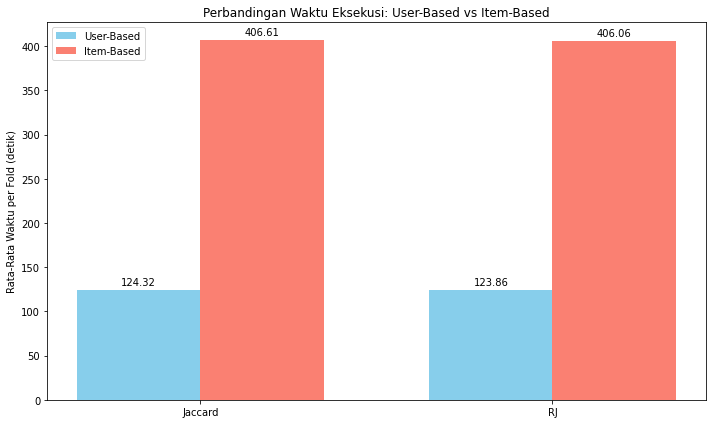

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data waktu rata-rata per fold (dalam detik)
methods = ['Jaccard', 'RJ']
user_based_times = [124.32, 123.86]
item_based_times = [406.61, 406.06]

x = np.arange(len(methods))  # Lokasi label
width = 0.35  # Lebar bar

fig, ax = plt.subplots(figsize=(10, 6))

# Buat bar chart
bars1 = ax.bar(x - width/2, user_based_times, width, label='User-Based', color='skyblue')
bars2 = ax.bar(x + width/2, item_based_times, width, label='Item-Based', color='salmon')

# Label dan judul
ax.set_ylabel('Rata-Rata Waktu per Fold (detik)')
ax.set_title('Perbandingan Waktu Eksekusi: User-Based vs Item-Based')
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend()

# Tambahkan nilai di atas bar
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', 
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), 
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()


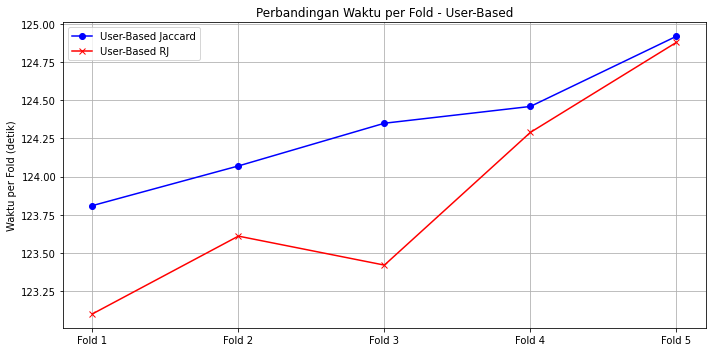

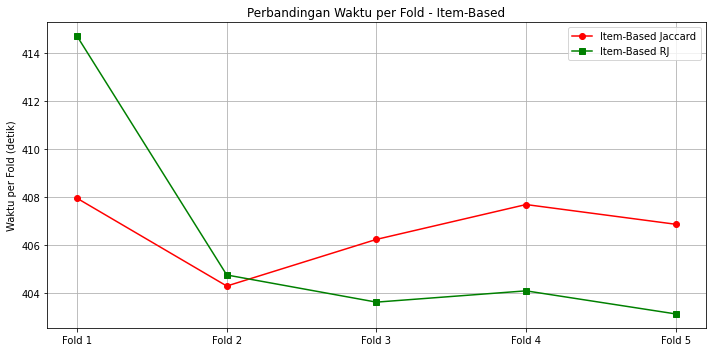

In [ ]:
# Data waktu per fold (dalam detik)
folds = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4', 'Fold 5']

# User-Based
user_jaccard = [123.81, 124.07, 124.35, 124.46, 124.92]
user_rj = [123.10, 123.61, 123.42, 124.29, 124.88]

# Item-Based
item_jaccard = [407.95, 404.30, 406.24, 407.69, 406.87]
item_rj = [414.69, 404.76, 403.63, 404.10, 403.14]

x = range(len(folds))

# Grafik 1: User-Based
plt.figure(figsize=(10, 5))
plt.plot(x, user_jaccard, marker='o', label='User-Based Jaccard', color='blue')
plt.plot(x, user_rj, marker='x', label='User-Based RJ', color='red')
plt.xticks(x, folds)
plt.ylabel('Waktu per Fold (detik)')
plt.title('Perbandingan Waktu per Fold - User-Based')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Grafik 2: Item-Based
plt.figure(figsize=(10, 5))
plt.plot(x, item_jaccard, marker='o', label='Item-Based Jaccard', color='red')
plt.plot(x, item_rj, marker='s', label='Item-Based RJ', color='green')
plt.xticks(x, folds)
plt.ylabel('Waktu per Fold (detik)')
plt.title('Perbandingan Waktu per Fold - Item-Based')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
